In [2]:
%load_ext zipline

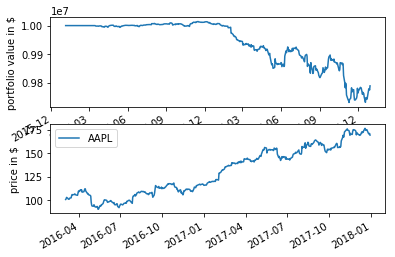

,AAPL,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2016-01-04 21:00:00+00:00,NaN,NaN,0.000000,NaN,-0.013983,NaN,NaN,0.0000,1.000000e+07,0.0,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,1,[],0.0
2016-01-05 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.012312,0.175987,0.000000,0.0000,1.000000e+07,0.0,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,2,[],0.0
2016-01-06 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.024771,0.137848,0.000000,0.0000,1.000000e+07,0.0,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,3,[],0.0
2016-01-07 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.048168,0.167866,0.000000,0.0000,1.000000e+07,0.0,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,4,[],0.0
2016-01-08 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.058601,0.145652,0.000000,0.0000,1.000000e+07,0.0,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,5,[],0.0
2016-01-11 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.057684,0.154952,0.000000,0.0000,1.000000e+07,0.0,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,6,[],0.0
2016-01-12 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.050077,0.177553,0.000000,0.0000,1.000000e+07,0.0,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,7,[],0.0
2016-01-13 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.073773,0.192030,0.000000,0.0000,1.000000e+07,0.0,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,8,[],0.0
2016-01-14 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.058567,0.225895,0.000000,0.0000,1.000000e+07,0.0,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,9,[],0.0
2016-01-15 21:00:00+00:00,NaN,0.000000,0.000000,0.000000,-0.078776,0.225684,0.000000,0.0000,1.000000e+07,0.0,...,0.0,0.0,0,NaN,1.000000e+07,0.0,0.0,10,[],0.0


In [34]:
%%zipline --start 2016-1-1 --end 2018-1-1

# strategy: always set limit orders with constant offset

from zipline.api import (
    order, 
    order_target, 
    order_target_percent,
    record, 
    symbol)

import matplotlib.pyplot as plt
import numpy as np
import pickle

 

def getOffset(history, T): 
    offset = 0
    for pre, curr in zip(history[:T-1], history[1:]):
        offset += (curr - pre)**2
    return round(offset/T)
        
        
        
def initialize(context):
    context.amount = 100
    context.i = 0
    context.warmup_i = 30 # we use the first warmup_i day's data to get CDF
    context.asset = symbol('AAPL')
    context.lr = 0.01 # maximum offset
      
            
def handle_data(context, data):   
    context.i += 1
    if context.i <= context.warmup_i+10:
        return
    
    history = data.history(context.asset, 'price', bar_count= context.warmup_i, frequency="1d")
    offset = context.lr * getOffset(history, context.warmup_i)
    price = data.current(context.asset, 'price')  
    order(context.asset, context.amount, limit_price = price - offset)
    order(context.asset, -context.amount, limit_price = price + offset)
    
    # Save values for later inspection
    record(AAPL=data.current(context.asset, 'price'))

    
def analyze(context, perf):
    fig = plt.figure()
     
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')
    
    ax2 = fig.add_subplot(212)
    perf['AAPL'].plot(ax=ax2)
    
    ax2.set_ylabel('price in $')
    plt.legend(loc=0)
     
    plt.show()
     
    